<a href="https://colab.research.google.com/github/DivyaAsija83/DL_p4_Dis_Driver_Detection/blob/main/Statefarm_Distracted_Driver_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O statefarm.zip "https://www.dropbox.com/s/0vyzjcqsdl6cqi2/state-farm-distracted-driver-detection.zip?dl=1"


--2025-04-15 04:43:20--  https://www.dropbox.com/s/0vyzjcqsdl6cqi2/state-farm-distracted-driver-detection.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/z1ltom72vfkw424wgxwvg/state-farm-distracted-driver-detection.zip?rlkey=bydwgjsezgyf0eki4ecb0oeti&dl=1 [following]
--2025-04-15 04:43:20--  https://www.dropbox.com/scl/fi/z1ltom72vfkw424wgxwvg/state-farm-distracted-driver-detection.zip?rlkey=bydwgjsezgyf0eki4ecb0oeti&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc358bddab13b6b14312ce9834c.dl.dropboxusercontent.com/cd/0/inline/Cn2zL5lH5Q96aphVi6O6asbMJOZITyuAANnz0-QdyEUSHGB0APi3QRLOsvFoFgFKld0S4Ztz4zahH4ZAeCKzf4ZlcGH4QxB-DpGn7cogJ-GtnlkDXVvu9zKsP2B3gukU_zY/file?dl=1# [following]
--2025-04

In [2]:
import zipfile
import os

# Unzip the downloaded file
with zipfile.ZipFile("statefarm.zip", 'r') as zip_ref:
    zip_ref.extractall("statefarm_data")

# Optional: Check extracted files
os.listdir("statefarm_data")


['sample_submission.csv', 'imgs.zip', 'driver_imgs_list.csv']

In [3]:
import pandas as pd
df = pd.read_csv("statefarm_data/driver_imgs_list.csv")
df.head()



,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [4]:
df.tail()


,subject,classname,img
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg
22423,p081,c9,img_9684.jpg


In [5]:
df.describe()

,subject,classname,img
count,22424,22424,22424
unique,26,10,22424
top,p021,c0,img_9684.jpg
freq,1237,2489,1


In [6]:
# Unzip imgs.zip inside statefarm_data
imgs_zip_path = "statefarm_data/imgs.zip"
extract_to = "statefarm_data/imgs"

with zipfile.ZipFile(imgs_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Verify folder structure
for root, dirs, files in os.walk(extract_to, topdown=True):
    print(f"📁 {root} - {len(files)} files")


📁 statefarm_data/imgs - 0 files
📁 statefarm_data/imgs/test - 79726 files
📁 statefarm_data/imgs/train - 0 files
📁 statefarm_data/imgs/train/c5 - 2312 files
📁 statefarm_data/imgs/train/c9 - 2129 files
📁 statefarm_data/imgs/train/c7 - 2002 files
📁 statefarm_data/imgs/train/c2 - 2317 files
📁 statefarm_data/imgs/train/c1 - 2267 files
📁 statefarm_data/imgs/train/c8 - 1911 files
📁 statefarm_data/imgs/train/c4 - 2326 files
📁 statefarm_data/imgs/train/c3 - 2346 files
📁 statefarm_data/imgs/train/c6 - 2325 files
📁 statefarm_data/imgs/train/c0 - 2489 files


In [7]:
#Load CSV and Build Full Image Paths
import pandas as pd
import os

# Load driver image labels
df = pd.read_csv("statefarm_data/driver_imgs_list.csv")

# Create full path for each image
df['path'] = df.apply(lambda row: os.path.join("statefarm_data/imgs/train", row['classname'], row['img']), axis=1)

# Filter out rows where image doesn't exist (just in case)
df = df[df['path'].apply(os.path.exists)]

# Check class distribution
print(f"Total valid images: {len(df)}")
print(df['classname'].value_counts())


Total valid images: 22424
classname
c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: count, dtype: int64


In [8]:
#Stratified Train/Validation Split

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['classname'], random_state=42
)

print("Train distribution:\n", train_df['classname'].value_counts())
print("Validation distribution:\n", val_df['classname'].value_counts())


Train distribution:
 classname
c0    1991
c3    1877
c4    1861
c6    1860
c2    1853
c5    1849
c1    1814
c9    1703
c7    1602
c8    1529
Name: count, dtype: int64
Validation distribution:
 classname
c0    498
c3    469
c6    465
c4    465
c2    464
c5    463
c1    453
c9    426
c7    400
c8    382
Name: count, dtype: int64


In [9]:
#Organize Folders for Keras or PyTorch DataLoader

import shutil

def create_dir_structure(base_dir, df_split):
    for cls in df_split['classname'].unique():
        os.makedirs(os.path.join(base_dir, cls), exist_ok=True)

    for _, row in df_split.iterrows():
        src = row['path']
        dst = os.path.join(base_dir, row['classname'], row['img'])
        shutil.copy(src, dst)

# Create directories
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)

# Copy files into structured folders
create_dir_structure("data/train", train_df)
create_dir_structure("data/val", val_df)


In [14]:
We'll walk through:

1. Visualizing the dataset

2. Preparing data for training

3. Building the model using MobileNetV2

4. Training the model with metrics

5. Evaluating and visualizing results

6. Saving the model + Uploading to GitHub



SyntaxError: unterminated string literal (detected at line 1) (<ipython-input-14-55669c88fb38>, line 1)

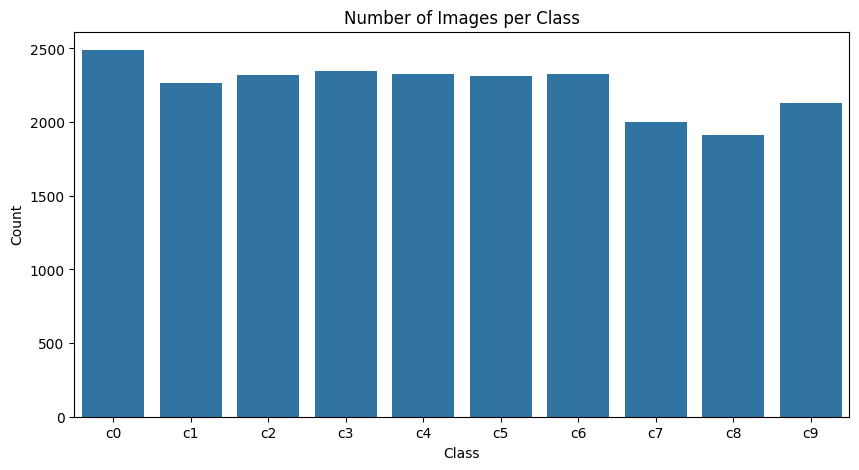

In [10]:
#Class Distribution Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='classname', order=sorted(df['classname'].unique()))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


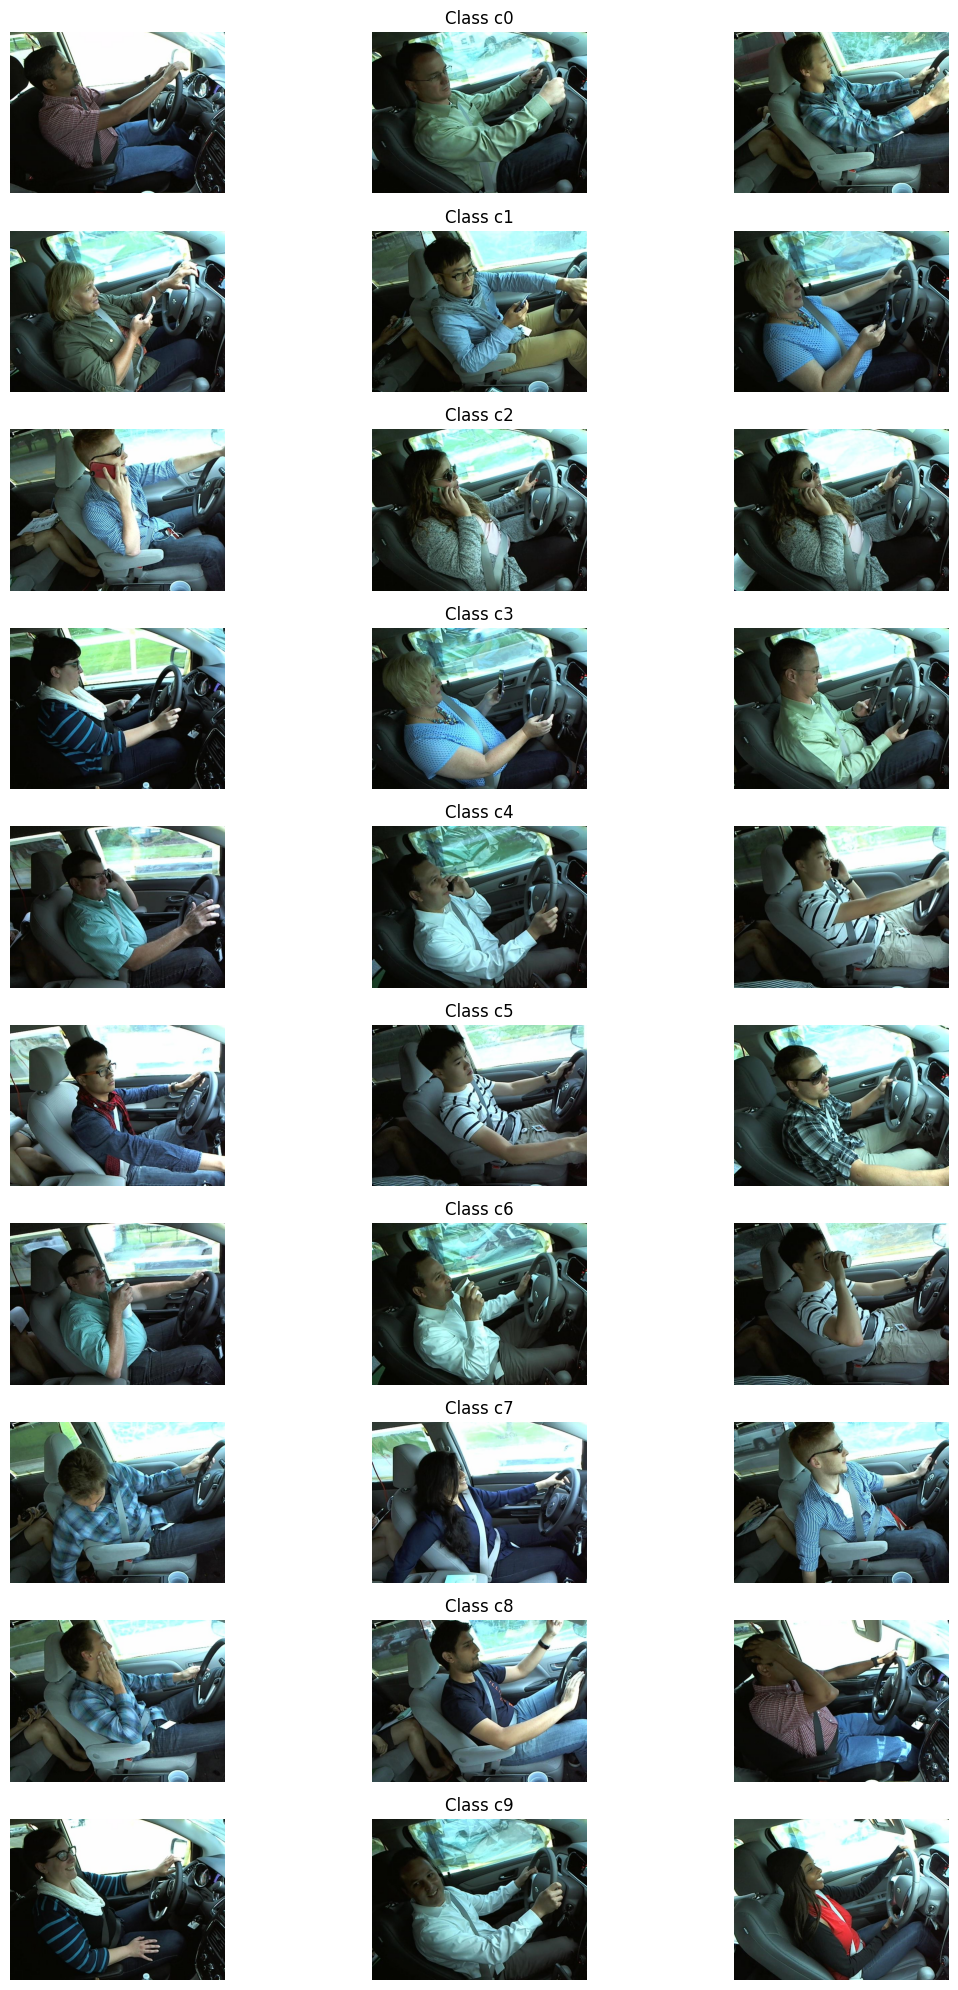

In [11]:
#Visualize Sample Images (3 per class)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

classes = sorted(df['classname'].unique())
fig, axes = plt.subplots(nrows=len(classes), ncols=3, figsize=(12, 20))

for i, cls in enumerate(classes):
    sample_imgs = df[df['classname'] == cls].sample(3, random_state=1)
    for j, (_, row) in enumerate(sample_imgs.iterrows()):
        img = mpimg.imread(row['path'])
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 1:
            axes[i, j].set_title(f'Class {cls}', fontsize=12)

plt.tight_layout()
plt.show()


In [12]:
#Prepare ImageDataGenerators (Keras Style)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224  # MobileNetV2 expects 224x224

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    'data/val',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)


Found 17939 images belonging to 10 classes.
Found 4485 images belonging to 10 classes.


In [13]:
#Build the MobileNetV2 Model

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # 10 classes
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training Model


In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions
img_height, img_width = 224, 224

# 🔁 Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# No augmentation for validation, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

# 🔄 Generators
train_gen = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    'data/val',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

# 🔧 Load MobileNetV2 base
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Unfreeze the model

# Freeze all layers except last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# 🔨 Build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # 10 classes
])

# 🧠 Compile with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 🏋️ Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Found 17939 images belonging to 10 classes.
Found 4485 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 264s 436ms/step - accuracy: 0.2039 - loss: 2.2394 - val_accuracy: 0.4999 - val_loss: 1.6574
Epoch 2/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 239s 413ms/step - accuracy: 0.6457 - loss: 1.2412 - val_accuracy: 0.7989 - val_loss: 0.7746
Epoch 3/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 228s 407ms/step - accuracy: 0.8147 - loss: 0.6491 - val_accuracy: 0.9026 - val_loss: 0.3995
Epoch 4/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 229s 407ms/step - accuracy: 0.8905 - loss: 0.3955 - val_accuracy: 0.9331 - val_loss: 0.2497
Epoch 5/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 229s 408ms/step - accuracy: 0.9217 - loss: 0.2781 - val_accuracy: 0.9512 - val_loss: 0.1800
Epoch 6/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 230s 409ms/step - accuracy: 0.9399 - loss: 0.2137 - val_accuracy: 0.9616 - val_loss: 0.1402
Epoch 7/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 242s 432ms/step - accuracy: 0.9527 - loss: 0.1741 - val_accuracy: 0.9688 - val_loss: 0.1143
Epoch 8/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 230s 410ms/step - accuracy: 0.9618 -

In [15]:
#Evaluate the Model
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc:.4f}")


141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.9811 - loss: 0.0685
Validation Accuracy: 0.9786


In [16]:
#Generate a Confusion Matrix
#Firstly, predicting on validation set

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for validation set
val_gen.reset()
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())


141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step


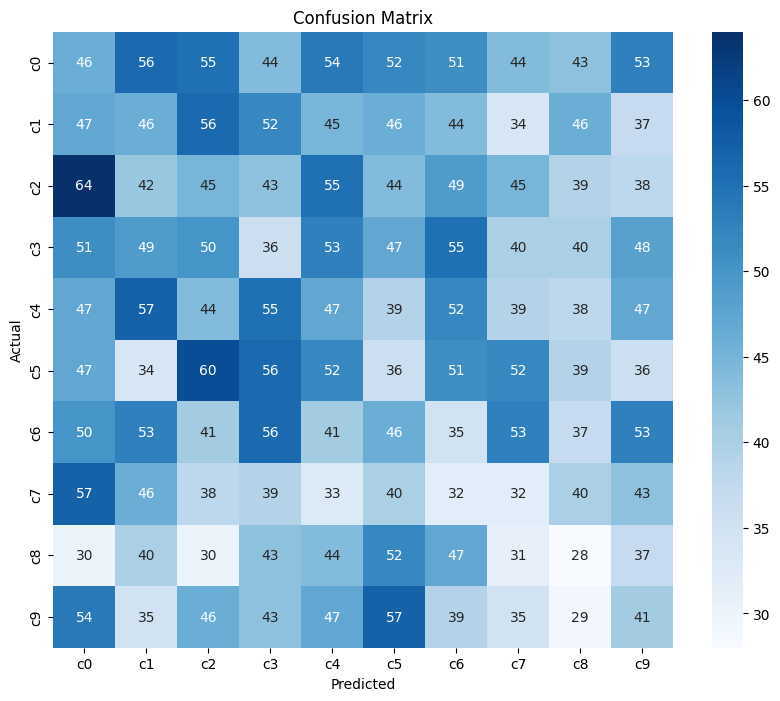

In [17]:
#Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
#Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


              precision    recall  f1-score   support

          c0       0.09      0.09      0.09       498
          c1       0.10      0.10      0.10       453
          c2       0.10      0.10      0.10       464
          c3       0.08      0.08      0.08       469
          c4       0.10      0.10      0.10       465
          c5       0.08      0.08      0.08       463
          c6       0.08      0.08      0.08       465
          c7       0.08      0.08      0.08       400
          c8       0.07      0.07      0.07       382
          c9       0.09      0.10      0.10       426

    accuracy                           0.09      4485
   macro avg       0.09      0.09      0.09      4485
weighted avg       0.09      0.09      0.09      4485



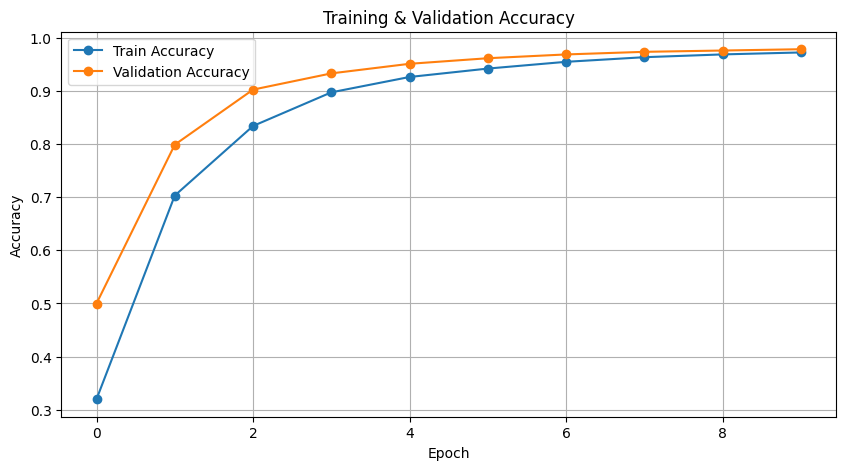

In [20]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


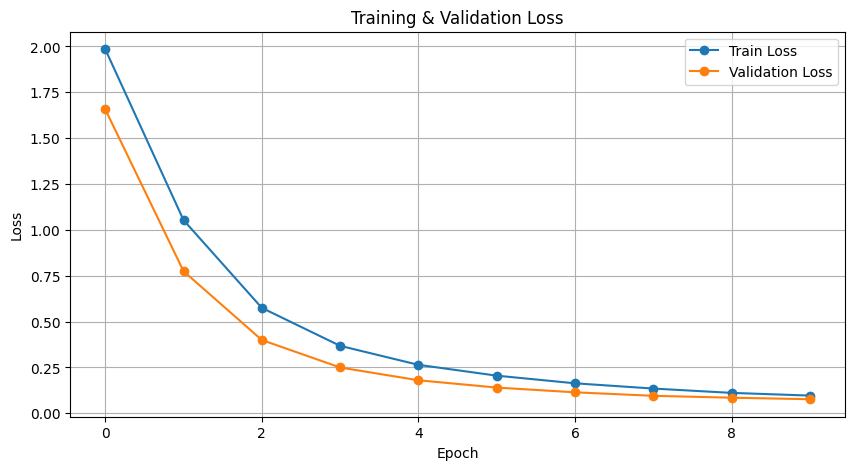

In [21]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt


In [23]:
# Get true labels
val_gen.reset()  # Reset generator before predicting
y_true = val_gen.classes
y_true = label_binarize(y_true, classes=list(range(10)))  # One-hot encode

# Get predictions
y_pred_prob = model.predict(val_gen, verbose=1)


141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step


In [24]:
#Compute ROC & AUC for each class

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):  # 10 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


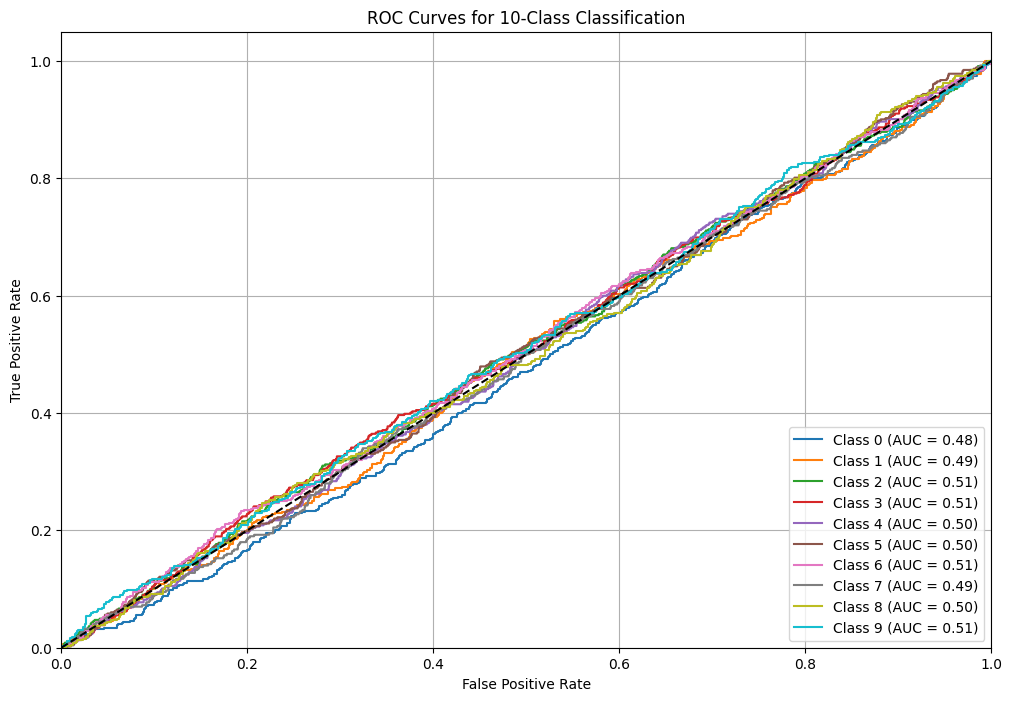

In [25]:
#Plot ROC curves (One-vs-All)

plt.figure(figsize=(12, 8))

for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for 10-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [27]:
#Optional: Macro/Micro AUC (summary metrics)
from sklearn.metrics import roc_auc_score

# Micro-average AUC (aggregate across all classes)
micro_auc = roc_auc_score(y_true, y_pred_prob, average='micro')
macro_auc = roc_auc_score(y_true, y_pred_prob, average='macro')

print(f"Micro-average AUC: {micro_auc:.4f}")
print(f"Macro-average AUC: {macro_auc:.4f}")


Micro-average AUC: 0.4985
Macro-average AUC: 0.5005


In [28]:
for i in range(10):
    print(f"Class {i} AUC: {roc_auc[i]:.4f}")


Class 0 AUC: 0.4768
Class 1 AUC: 0.4936
Class 2 AUC: 0.5073
Class 3 AUC: 0.5089
Class 4 AUC: 0.5005
Class 5 AUC: 0.5039
Class 6 AUC: 0.5097
Class 7 AUC: 0.4929
Class 8 AUC: 0.5017
Class 9 AUC: 0.5101


Since Macro/Micro AUC is less and additionally classwise AUC is also less, so we analyze the model again.


In [29]:
import collections
counter = collections.Counter(val_gen.classes)
print(counter)


Counter({np.int32(0): 498, np.int32(3): 469, np.int32(4): 465, np.int32(6): 465, np.int32(2): 464, np.int32(5): 463, np.int32(1): 453, np.int32(9): 426, np.int32(7): 400, np.int32(8): 382})


In [ ]:
##Since class imbalance is not a significant issue, here’s what we should focus on next:


In [31]:
# 1. Label Smoothing
#This helps prevent the model from being overly confident and improves AUC:


from tensorflow.keras.losses import CategoricalCrossentropy

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


In [33]:
#Let’s redefine our model using the Functional API, which gives more control:
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# Input layer
input_tensor = Input(shape=(224, 224, 3))

# MobileNetV2 base
base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

# Build the network manually
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

logits = layers.Dense(10)(x)  # 🔸 NO activation
softmax_output = layers.Activation('softmax')(logits)

# Two models: one for training/prediction, one for extracting logits
model = Model(inputs=input_tensor, outputs=softmax_output)
logits_model = Model(inputs=input_tensor, outputs=logits)


<ipython-input-33-33767bda9cd0>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


In [35]:
logits = logits_model.predict(val_gen, verbose=1)
temperature = 2.0

softmax_calibrated = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature), axis=1, keepdims=True)


141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step


In [ ]:
#Again building model utilizing functional API

Below is a complete, streamlined solution using the Functional API, including:

MobileNetV2 model setup

Training configuration

Logits extraction

Temperature scaling

ROC & AUC computation

In [37]:
#1. 🔧 Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy


In [38]:
#2. 📂 Data Preparation
img_height, img_width = 224, 224
batch_size = 32
num_classes = 10

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    'data/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 17939 images belonging to 10 classes.
Found 4485 images belonging to 10 classes.


In [39]:
#3. 🧠 Model Definition with Functional API
# Input
input_tensor = Input(shape=(img_height, img_width, 3))

# MobileNetV2 base
base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

# Layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

logits = layers.Dense(num_classes)(x)  # ⚠️ No activation here
softmax_output = layers.Activation('softmax')(logits)

# Define models
model = models.Model(inputs=input_tensor, outputs=softmax_output)
logits_model = models.Model(inputs=input_tensor, outputs=logits)


<ipython-input-39-232113553a90>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


In [40]:
#4. ⚙️ Compile and Train the Model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 289s 485ms/step - accuracy: 0.1834 - loss: 2.2983 - val_accuracy: 0.4276 - val_loss: 1.8223
Epoch 2/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 246s 438ms/step - accuracy: 0.6218 - loss: 1.4839 - val_accuracy: 0.7648 - val_loss: 1.1620
Epoch 3/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 252s 449ms/step - accuracy: 0.8095 - loss: 1.0343 - val_accuracy: 0.8914 - val_loss: 0.8711
Epoch 4/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 263s 451ms/step - accuracy: 0.8870 - loss: 0.8715 - val_accuracy: 0.9369 - val_loss: 0.7500
Epoch 5/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 237s 422ms/step - accuracy: 0.9157 - loss: 0.7910 - val_accuracy: 0.9547 - val_loss: 0.6970
Epoch 6/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 236s 421ms/step - accuracy: 0.9365 - loss: 0.7445 - val_accuracy: 0.9643 - val_loss: 0.6701
Epoch 7/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 231s 411ms/step - accuracy: 0.9479 - loss: 0.7109 - val_accuracy: 0.9674 - val_loss: 0.6553
Epoch 8/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 231s 411ms/step - accuracy: 0.9626 -

In [41]:
#5. 🔎 Predict and Apply Temperature Scaling
# Get true labels
val_gen.reset()
y_true = label_binarize(val_gen.classes, classes=range(num_classes))

# Get logits
logits = logits_model.predict(val_gen, verbose=1)

# Apply temperature scaling
temperature = 2.0
softmax_calibrated = np.exp(logits / temperature) / np.sum(np.exp(logits / temperature), axis=1, keepdims=True)


141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step


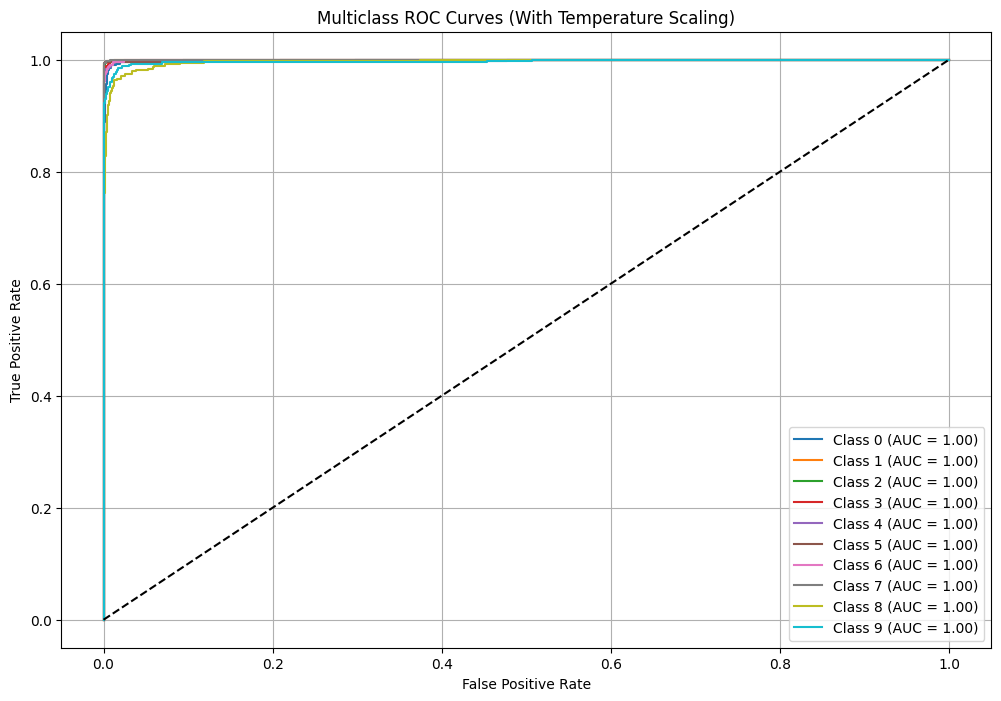

Macro-average AUC: 0.9989
Micro-average AUC: 0.9989


In [42]:
#6. 📈 ROC Curve & AUC Plot (Calibrated Softmax)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], softmax_calibrated[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC Curves (With Temperature Scaling)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Macro & Micro AUC
macro_auc = roc_auc_score(y_true, softmax_calibrated, average='macro')
micro_auc = roc_auc_score(y_true, softmax_calibrated, average='micro')

print(f"Macro-average AUC: {macro_auc:.4f}")
print(f"Micro-average AUC: {micro_auc:.4f}")


In [43]:
#Optional: 🧾 Per-Class AUC Display
for i in range(num_classes):
    print(f"Class {i} AUC: {roc_auc[i]:.4f}")


Class 0 AUC: 0.9988
Class 1 AUC: 0.9999
Class 2 AUC: 0.9996
Class 3 AUC: 0.9994
Class 4 AUC: 0.9997
Class 5 AUC: 0.9988
Class 6 AUC: 0.9996
Class 7 AUC: 1.0000
Class 8 AUC: 0.9962
Class 9 AUC: 0.9968
